In [69]:

from typing import Callable, Optional
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import DataLoader, Dataset
from torch_geometric.nn import VGAE, GATConv, GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from typing import Any, List
import os
import os.path as osp
from copy import copy
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import pickle

#empty cuda cache
torch.cuda.empty_cache()


import torch
from torch_geometric.data import Data

def remove_bidirectional_duplicates(edge_index, edge_attr):
    # Initialize containers for unique edges and their attributes
    unique_edge_list = []
    unique_edge_attr_list = []
    
    # Create a dictionary to track seen edges and their inverse
    seen_edges = {}

    for i, edge in enumerate(edge_index.t().tolist()):
        edge_tuple = tuple(edge)
        inverse_edge_tuple = tuple(edge[::-1])

        # If the edge or its inverse hasn't been seen, add it to the unique lists
        if edge_tuple not in seen_edges and inverse_edge_tuple not in seen_edges:
            seen_edges[edge_tuple] = i  # Mark this edge as seen
            unique_edge_list.append(edge)
            unique_edge_attr_list.append(edge_attr[i])
        elif inverse_edge_tuple in seen_edges:
            # If the inverse edge was seen but this direction is needed (for genuinely bidirectional edges), keep it
            # This part depends on whether you want to strictly remove inverse duplicates
            # or allow one direction to be represented. Adjust according to your exact needs.
            pass

    # Convert the lists back to tensors
    filtered_edge_index = torch.tensor(unique_edge_list).t().contiguous()
    filtered_edge_attr = torch.stack(unique_edge_attr_list)

    return filtered_edge_index, filtered_edge_attr

def create_line_graph(data):
    # Remove bidirectional duplicates while keeping the directed nature and adjusting edge attributes accordingly
    edge_index_directed, edge_attr_directed = remove_bidirectional_duplicates(data.edge_index, data.edge_attr)
    
    # The rest of your line graph creation logic...
    num_edges = edge_index_directed.size(1)
    x_prime = edge_attr_directed  # Edge attributes of G become node features of G'

    # add one extra node feature to x_prime
    x_prime = torch.cat([x_prime, torch.randn((num_edges, 1))], dim=1)

    

    connections = []
    for i in range(num_edges):
        for j in range(i + 1, num_edges):
            if len(set(edge_index_directed[:, i].tolist()) & set(edge_index_directed[:, j].tolist())) > 0:
                connections.append([i, j])
                connections.append([j, i])  # Assuming undirected connections in G'

    edge_index_prime = torch.tensor(connections).t().contiguous()
    
    # Placeholder: Create edge attributes for G' (e.g., based on node features of G)
    # Ensure to replace this with your actual logic for attribute transformation
    # edge_attr_prime = torch.randn((edge_index_prime.size(1), data.x.size(1)))  # Example feature transformation
    
    data_prime = Data(x=x_prime, edge_index=edge_index_prime)
    
    return data_prime





class GraphEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, encoding_dim):
        super(GraphEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, encoding_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x=F.dropout(x,p=0.2)
        z = self.conv2(x, edge_index)
        z=F.dropout(z,p=0.2)
        return z

# Define the graph decoder model
class GraphDecoder(torch.nn.Module):
    def __init__(self, encoding_dim, hidden_dim, output_dim):
        super(GraphDecoder, self).__init__()
        self.conv1 = GCNConv(encoding_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, z, edge_index):
        x = F.relu(self.conv1(z, edge_index))
        x=F.dropout(x,p=0.2)
        x = self.conv2(x, edge_index)
        x=F.dropout(x,p=0.2)

        return x
    


    
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_node = GraphEncoder(20, 16, 16).to(DEVICE)
encoder_edge= GraphEncoder(20, 16, 16).to(DEVICE)
decoder_node = GraphDecoder(16, 16, 20).to(DEVICE)
decoder_edge = GraphDecoder(16, 16, 20).to(DEVICE)


encoder_node.load_state_dict(torch.load("encoder_weights_epoch_151.pth"))
decoder_node.load_state_dict(torch.load("decoder_weights_epoch_151.pth"))

encoder_edge.load_state_dict(torch.load("encoder_weights_dual_epoch_11.pth"))
decoder_edge.load_state_dict(torch.load("decoder_weights_dual_epoch_11.pth"))

<All keys matched successfully>

In [3]:

def get_features(path):
    data=torch.load(f"Seperated_dataset/{path}/train_feature.pt")
    label=torch.load(f"Seperated_dataset/{path}/train_labels.pt")


    test_data=torch.load(f"Seperated_dataset/{path}/test_feature.pt")
    test_label=torch.load(f"Seperated_dataset/{path}/test_labels.pt")

    bert_data=torch.load(f"Seperated_dataset/{path}/train_feature_bert.pt")
    test_bert_data=torch.load(f"Seperated_dataset/{path}/test_feature_bert.pt")   

    bert_labels=torch.load(f"Seperated_dataset/{path}/train_labels_bert.pt")
    bert_labels_test=torch.load(f"Seperated_dataset/{path}/test_labels_bert.pt")




    dual_graphs=[]
    graphs=[]
    dual_graphs_test=[]
    combined_graphs_test=[]


    label_final=[]
    label_final_test=[]


    bert_final=[]
    bert_final_test=[]


    for graph,label,bert_data,bert_label in tqdm(zip(data,label,bert_data,bert_labels)): 
            
        
            if(graph is None):
                continue
            if(graph.edge_index is None):
                continue
            if(graph.edge_index.shape[0]==0 or graph.edge_index.shape[1]==0):
                continue
        
            
            graph = graph.to('cpu')
            dual_graph=create_line_graph(graph)


            if(dual_graph is None):
                continue
            if(dual_graph.edge_index is None):
                continue
            if(dual_graph.edge_index.shape[0]==0 or dual_graph.edge_index.shape[1]==0):
                continue
        
            dual_graphs.append(dual_graph)
            graphs.append(graph)
            label_final.append(label)
            bert_final.append(bert_data.squeeze(0))

        




    i=0
    for graph,label,bert_data,bert_test_label in tqdm(zip(test_data,test_label,test_bert_data,bert_labels_test)):
                    
                
                    if(graph is None):
                        continue
                    if(graph.edge_index is None):
                        continue
                    if(graph.edge_index.shape[0]==0 or graph.edge_index.shape[1]==0):
                        continue


                    
                    graph = graph.to('cpu')
                
                    dual_graph=create_line_graph(graph)
                
                    if(dual_graph is None):
                        continue
                    if(dual_graph.edge_index is None):
                        continue
                    if(dual_graph.edge_index.shape[0]==0 or dual_graph.edge_index.shape[1]==0):
                        continue
                
                    dual_graphs_test.append(dual_graph)
                    combined_graphs_test.append(graph)
                    label_final_test.append(label)
                    bert_final_test.append(bert_data)
    


    encoded_datas_node=[]
    encoded_datas_edge=[]
    actual_labels=[]

    encoded_datas_test_node=[]
    encoded_datas_test_edge=[]
    actual_labels_test=[]


    for data,label in tqdm(zip(graphs,label_final)):
        encoder_node.eval()
        with torch.no_grad():
            # print(data)
            if(data.edge_index is None):
                # print("edge index is none")
                continue
            if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
                # print("edge index shape is 0")
                continue    
            g_data=data.to(DEVICE)
            g_data.edge_index=g_data.edge_index.long()

            z = encoder_node(g_data.x, g_data.edge_index)
            encoded_datas_node.append(z)
            actual_labels.append(label)


    for data,label in tqdm(zip(dual_graphs,label_final)):
        encoder_edge.eval()
        with torch.no_grad():
            # print(data)
            if(data.edge_index is None):
                continue
            if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
                continue    
            g_data=data.to(DEVICE)
            g_data.edge_index=g_data.edge_index.long()

            z = encoder_edge(g_data.x, g_data.edge_index)
            encoded_datas_edge.append(z)
            # actual_labels.append(label)



    for data,label in tqdm(zip(combined_graphs_test,label_final_test)):
        encoder_node.eval()
        with torch.no_grad():
            # print(data)
            if(data.edge_index is None):
                continue
            if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
                continue    
            g_data=data.to(DEVICE)
            g_data.edge_index=g_data.edge_index.long()

            z = encoder_node(g_data.x, g_data.edge_index)
            encoded_datas_test_node.append(z)
            actual_labels_test.append(label)


    for data,label in tqdm(zip(dual_graphs_test,label_final_test)):
        encoder_edge.eval()
        with torch.no_grad():
            # print(data)
            if(data.edge_index is None):
                continue
            if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
                continue    
            g_data=data.to(DEVICE)
            g_data.edge_index=g_data.edge_index.long()

            z = encoder_edge(g_data.x, g_data.edge_index)
            encoded_datas_test_edge.append(z)
            # actual_labels_test.append(label)



    for i in range(len(encoded_datas_node)):
        encoded_datas_node[i]=torch.mean(encoded_datas_node[i],dim=0)
        # detach at cp
        encoded_datas_node[i]=encoded_datas_node[i].detach().cpu().numpy()
        encoded_datas_node[i]=torch.tensor(encoded_datas_node[i])


    for i in range(len(encoded_datas_edge)):
        encoded_datas_edge[i]=torch.mean(encoded_datas_edge[i],dim=0)
        # detach at cp
        encoded_datas_edge[i]=encoded_datas_edge[i].detach().cpu().numpy()
        encoded_datas_edge[i]=torch.tensor(encoded_datas_edge[i])


    for i in range(len(encoded_datas_test_node)):

        encoded_datas_test_node[i]=torch.mean(encoded_datas_test_node[i],dim=0)
        # detach at cp

        
        encoded_datas_test_node[i]=encoded_datas_test_node[i].detach().cpu().numpy()
        encoded_datas_test_node[i]=torch.tensor(encoded_datas_test_node[i])


    for i in range(len(encoded_datas_test_edge)):

        encoded_datas_test_edge[i]=torch.mean(encoded_datas_test_edge[i],dim=0)
        # detach at cp
        encoded_datas_test_edge[i]=encoded_datas_test_edge[i].detach().cpu().numpy()
        encoded_datas_test_edge[i]=torch.tensor(encoded_datas_test_edge[i])



    encoded_datas_combined=[]
    encoded_datas_test_combined=[]

    for i in range(len(encoded_datas_node)):
        bert_final[i]=bert_final[i].to('cpu').squeeze(0)
        encoded_datas_combined.append(torch.cat([encoded_datas_node[i],encoded_datas_edge[i],bert_final[i]],dim=0))
        
        # encoded_datas_combined.append(bert_final[i])

    for i in range(len(encoded_datas_test_node)):
        
        bert_final_test[i]=bert_final_test[i].to('cpu').squeeze(0)
        encoded_datas_test_combined.append(torch.cat([encoded_datas_test_node[i],encoded_datas_test_edge[i],bert_final_test[i]],dim=0))
        # encoded_datas_test_combined.append(bert_final_test[i])


    
    return encoded_datas_combined,actual_labels,encoded_datas_test_combined,actual_labels_test
            



                    


In [75]:

def get_features(path):
    data=torch.load(f"Seperated_dataset/{path}/train_feature.pt")
    label=torch.load(f"Seperated_dataset/{path}/train_labels.pt")


    test_data=torch.load(f"Seperated_dataset/{path}/test_feature.pt")
    test_label=torch.load(f"Seperated_dataset/{path}/test_labels.pt")

    # bert_data=torch.load(f"Seperated_dataset/{path}/train_feature_bert.pt")
    # test_bert_data=torch.load(f"Seperated_dataset/{path}/test_feature_bert.pt")   

    # bert_labels=torch.load(f"Seperated_dataset/{path}/train_labels_bert.pt")
    # bert_labels_test=torch.load(f"Seperated_dataset/{path}/test_labels_bert.pt")




    dual_graphs=[]
    graphs=[]
    dual_graphs_test=[]
    combined_graphs_test=[]


    label_final=[]
    label_final_test=[]


    bert_final=[]
    bert_final_test=[]


    for graph,label in tqdm(zip(data,label)): 
            
        
            if(graph is None):
                continue
            if(graph.edge_index is None):
                continue
            if(graph.edge_index.shape[0]==0 or graph.edge_index.shape[1]==0):
                continue
        
            
            graph = graph.to('cpu')
            dual_graph=create_line_graph(graph)


            if(dual_graph is None):
                continue
            if(dual_graph.edge_index is None):
                continue
            if(dual_graph.edge_index.shape[0]==0 or dual_graph.edge_index.shape[1]==0):
                continue
        
            dual_graphs.append(dual_graph)
            graphs.append(graph)
            label_final.append(label)
            # bert_final.append(bert_data.squeeze(0))

        




    i=0
    for graph,label in tqdm(zip(test_data,test_label)):
                    
                
                    if(graph is None):
                        continue
                    if(graph.edge_index is None):
                        continue
                    if(graph.edge_index.shape[0]==0 or graph.edge_index.shape[1]==0):
                        continue


                    
                    graph = graph.to('cpu')
                
                    dual_graph=create_line_graph(graph)
                
                    if(dual_graph is None):
                        continue
                    if(dual_graph.edge_index is None):
                        continue
                    if(dual_graph.edge_index.shape[0]==0 or dual_graph.edge_index.shape[1]==0):
                        continue
                
                    dual_graphs_test.append(dual_graph)
                    combined_graphs_test.append(graph)
                    label_final_test.append(label)
                    # bert_final_test.append(bert_data)
    


    encoded_datas_node=[]
    encoded_datas_edge=[]
    actual_labels=[]

    encoded_datas_test_node=[]
    encoded_datas_test_edge=[]
    actual_labels_test=[]


    for data,label in tqdm(zip(graphs,label_final)):
        encoder_node.eval()
        with torch.no_grad():
            # print(data)
            if(data.edge_index is None):
                # print("edge index is none")
                continue
            if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
                # print("edge index shape is 0")
                continue    
            g_data=data.to(DEVICE)
            g_data.edge_index=g_data.edge_index.long()

            z = encoder_node(g_data.x, g_data.edge_index)
            encoded_datas_node.append(z)
            actual_labels.append(label)


    for data,label in tqdm(zip(dual_graphs,label_final)):
        encoder_edge.eval()
        with torch.no_grad():
            # print(data)
            if(data.edge_index is None):
                continue
            if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
                continue    
            g_data=data.to(DEVICE)
            g_data.edge_index=g_data.edge_index.long()

            z = encoder_edge(g_data.x, g_data.edge_index)
            encoded_datas_edge.append(z)
            # actual_labels.append(label)



    for data,label in tqdm(zip(combined_graphs_test,label_final_test)):
        encoder_node.eval()
        with torch.no_grad():
            # print(data)
            if(data.edge_index is None):
                continue
            if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
                continue    
            g_data=data.to(DEVICE)
            g_data.edge_index=g_data.edge_index.long()

            z = encoder_node(g_data.x, g_data.edge_index)
            encoded_datas_test_node.append(z)
            actual_labels_test.append(label)


    for data,label in tqdm(zip(dual_graphs_test,label_final_test)):
        encoder_edge.eval()
        with torch.no_grad():
            # print(data)
            if(data.edge_index is None):
                continue
            if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
                continue    
            g_data=data.to(DEVICE)
            g_data.edge_index=g_data.edge_index.long()

            z = encoder_edge(g_data.x, g_data.edge_index)
            encoded_datas_test_edge.append(z)
            # actual_labels_test.append(label)



    for i in range(len(encoded_datas_node)):
        encoded_datas_node[i]=torch.mean(encoded_datas_node[i],dim=0)
        # detach at cp
        encoded_datas_node[i]=encoded_datas_node[i].detach().cpu().numpy()
        encoded_datas_node[i]=torch.tensor(encoded_datas_node[i])


    for i in range(len(encoded_datas_edge)):
        encoded_datas_edge[i]=torch.mean(encoded_datas_edge[i],dim=0)
        # detach at cp
        encoded_datas_edge[i]=encoded_datas_edge[i].detach().cpu().numpy()
        encoded_datas_edge[i]=torch.tensor(encoded_datas_edge[i])


    for i in range(len(encoded_datas_test_node)):

        encoded_datas_test_node[i]=torch.mean(encoded_datas_test_node[i],dim=0)
        # detach at cp

        
        encoded_datas_test_node[i]=encoded_datas_test_node[i].detach().cpu().numpy()
        encoded_datas_test_node[i]=torch.tensor(encoded_datas_test_node[i])


    for i in range(len(encoded_datas_test_edge)):

        encoded_datas_test_edge[i]=torch.mean(encoded_datas_test_edge[i],dim=0)
        # detach at cp
        encoded_datas_test_edge[i]=encoded_datas_test_edge[i].detach().cpu().numpy()
        encoded_datas_test_edge[i]=torch.tensor(encoded_datas_test_edge[i])



    encoded_datas_combined=[]
    encoded_datas_test_combined=[]

    for i in range(len(encoded_datas_node)):
        # bert_final[i]=bert_final[i].to('cpu').squeeze(0)
        encoded_datas_combined.append(torch.cat([encoded_datas_node[i],encoded_datas_edge[i]],dim=0))
        
        # encoded_datas_combined.append(bert_final[i])

    for i in range(len(encoded_datas_test_node)):
        
        # bert_final_test[i]=bert_final_test[i].to('cpu').squeeze(0)
        encoded_datas_test_combined.append(torch.cat([encoded_datas_test_node[i],encoded_datas_test_edge[i]],dim=0))
        # encoded_datas_test_combined.append(bert_final_test[i])


    
    return encoded_datas_combined,actual_labels,encoded_datas_test_combined,actual_labels_test
            



                    


In [71]:
import numpy as np
#create a dataloader for the encoded data
class encoded_dataset(Dataset):
    def __init__(self, 
                 data: List[torch.Tensor],
                 labels: List[int],
                 root: str | None = None, 
                 transform: Callable[..., Any] | None = None, 
                 pre_transform: Callable[..., Any] | None = None, 
                 pre_filter: Callable[..., Any] | None = None, 
                 log: bool = True):
        super().__init__(root, transform, pre_transform, pre_filter, log)
        self.data = data
        self.labels = labels
        
    def len(self):
        return len(self.data)

    def get(self, idx):
        # Ensure that data and labels are torch.Tensors
        data_tensor = torch.Tensor(self.data[idx]) if isinstance(self.data[idx], np.ndarray) else self.data[idx]
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long) 
        # print(data_tensor)
        # print(label_tensor)
        return data_tensor, label_tensor

class EncodedClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super(EncodedClassifier, self).__init__()

        # Assuming the input shape is (batch_size, 1, 800)
        self.conv1 = nn.Conv1d(1, 128, kernel_size=3, padding=1)  # input channel is 1
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool = nn.MaxPool1d(2)  # Downsample

        # Adjust the input features for the first linear layer according to the output of conv and pool layers
        self.fc1 = nn.Linear(256 * 8, 512)  # Adjusted for the new flattened size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, out_features)
        
    def forward(self, x):
        # x shape is (batch_size, 1,32)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)  # shape now (batch_size, 128, 16)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # shape now (batch_size, 256, 8)
        
        # Flatten before passing to the dense layer
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 256*200)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer, no activation
        
        return x




#set seed for reproducibility
torch.manual_seed(0)



In [12]:
import glob 
filenames=glob.glob("Seperated_dataset/*")
filenames[0].split('\\')[1]

'nr-ahr'

In [76]:



from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


test_results={}

for file in filenames:

    print("------------------------------------------------------")
    print(file)
    print("------------------------------------------------------")
    print("\n")

    file=file.split('\\')[1]

    #split the data into train and valid


    encoded_datas_combined,actual_labels,encoded_datas_test_combined,actual_labels_test=get_features(file)
        
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(encoded_datas_combined, actual_labels, test_size=0.1, random_state=42)

    train_dataset=encoded_dataset(X_train,y_train)
    test_dataset=encoded_dataset(X_test,y_test)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)



    test_final_dataset=encoded_dataset(encoded_datas_test_combined,actual_labels_test)
    test_final_loader = DataLoader(test_final_dataset, batch_size=32, shuffle = False)

    #train the classifier

    classifier = EncodedClassifier(800, 1).to(DEVICE)

    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    epochs = 500

    #calculate the accuracy and roc_auc_score for each epoch. Save the best model based on the roc_auc_score

    from sklearn.metrics import accuracy_score, roc_auc_score

    best_auc = 0

    for epoch in range(epochs):
        classifier.train()
        train_loss = 0.0
        for data, target in train_loader:
            # Add a channel dimension to the data if necessary
            data = data.unsqueeze(1)  # This adds the channel dimension, converting [batch_size, sequence_length] to [batch_size, 1, sequence_length]
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = classifier(data)
            loss = criterion(output, target.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        # print(f"Epoch {epoch} - Train Loss: {train_loss}")
        
        classifier.eval()
        test_loss = 0.0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for data, target in test_final_loader:
                data = data.unsqueeze(1)  # This adds the channel dimension, converting [batch_size, sequence_length] to [batch_size, 1, sequence_length]
    
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = classifier(data)
                loss = criterion(output, target.unsqueeze(1).float())
                test_loss += loss.item() * data.size(0)
                y_true += target.cpu().numpy().tolist()
                y_pred += torch.sigmoid(output).cpu().numpy().tolist()
        test_loss = test_loss / len(test_final_loader.dataset)
        y_pred = [i[0] for i in y_pred]
        auc = roc_auc_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, [1 if i > 0.5 else 0 for i in y_pred])

        f1= f1_score(y_true, [1 if i > 0.5 else 0 for i in y_pred])
        precision=precision_score(y_true, [1 if i > 0.5 else 0 for i in y_pred])
        recall=recall_score(y_true, [1 if i > 0.5 else 0 for i in y_pred])


        # print(f"Epoch {epoch} - Test Loss: {test_loss} - AUC: {auc} - Accuracy: {accuracy}")
        if auc > best_auc:
            print(f"Saving best model with AUC: {auc}")
            torch.save(
                classifier.state_dict(),
                f"./Seperated_dataset/{file}/best_classifier_gae_combined_without_bert.pt"
            )
            best_auc = auc
            
            test_results[file]=[auc,accuracy,f1,precision,recall,best_auc]
    
    # write the test results for this file to a csv
    import csv
    with open('test_results_no_Bert.csv', 'w') as f:
        for key in test_results.keys():
            f.write("%s,%s\n"%(key,test_results[key]))

    #load the best classifier

------------------------------------------------------
Seperated_dataset\nr-ahr
------------------------------------------------------




1900it [00:03, 525.39it/s]
610it [00:01, 556.47it/s]
1894it [00:03, 566.55it/s]
1894it [00:02, 719.70it/s]
607it [00:00, 656.81it/s]
607it [00:00, 694.62it/s]


Saving best model with AUC: 0.8350063064956905
Saving best model with AUC: 0.848223670380492
Saving best model with AUC: 0.8491696447340761
Saving best model with AUC: 0.8494586924532268
Saving best model with AUC: 0.8513506411603953
Saving best model with AUC: 0.8533214210636956
Saving best model with AUC: 0.8542936724826571
------------------------------------------------------
Seperated_dataset\nr-ar
------------------------------------------------------




760it [00:03, 240.55it/s]
586it [00:01, 388.79it/s]
758it [00:01, 489.07it/s]
758it [00:01, 486.38it/s]
585it [00:01, 502.24it/s]
585it [00:01, 515.60it/s]


Saving best model with AUC: 0.6608493310063991
Saving best model with AUC: 0.6759744037230948
Saving best model with AUC: 0.6784467713787085
Saving best model with AUC: 0.6794648051192553
Saving best model with AUC: 0.7081151832460733
Saving best model with AUC: 0.7100058173356603
Saving best model with AUC: 0.7197498545666086
Saving best model with AUC: 0.7236765561372891
------------------------------------------------------
Seperated_dataset\nr-ar-lbd
------------------------------------------------------




606it [00:01, 470.05it/s]
582it [00:00, 771.56it/s]
604it [00:00, 859.06it/s]
604it [00:00, 866.21it/s]
580it [00:00, 833.78it/s]
580it [00:00, 722.76it/s]


Saving best model with AUC: 0.5559440559440559
Saving best model with AUC: 0.5799825174825175
Saving best model with AUC: 0.5878496503496503
Saving best model with AUC: 0.5992132867132867
Saving best model with AUC: 0.6134178321678322
Saving best model with AUC: 0.6234702797202797
Saving best model with AUC: 0.6282779720279721
Saving best model with AUC: 0.6309003496503497
Saving best model with AUC: 0.6453234265734266
Saving best model with AUC: 0.663243006993007
Saving best model with AUC: 0.666083916083916
Saving best model with AUC: 0.6770104895104896
Saving best model with AUC: 0.6831293706293706
Saving best model with AUC: 0.6881555944055944
Saving best model with AUC: 0.6962412587412588
Saving best model with AUC: 0.7124125874125875
Saving best model with AUC: 0.7325174825174825
Saving best model with AUC: 0.7344842657342658
Saving best model with AUC: 0.7445367132867132
Saving best model with AUC: 0.763986013986014
Saving best model with AUC: 0.7644230769230769
----------------

720it [00:01, 501.37it/s]
528it [00:00, 791.12it/s] 
717it [00:00, 794.65it/s]
717it [00:00, 904.90it/s]
527it [00:00, 934.14it/s]
527it [00:00, 926.89it/s]


Saving best model with AUC: 0.707229928541404
Saving best model with AUC: 0.7198928121059269
Saving best model with AUC: 0.7244640605296343
Saving best model with AUC: 0.7261454392601934
Saving best model with AUC: 0.7345523329129886
Saving best model with AUC: 0.737389659520807
Saving best model with AUC: 0.7443253467843631
------------------------------------------------------
Seperated_dataset\nr-er
------------------------------------------------------




1874it [00:02, 652.92it/s]
516it [00:00, 721.91it/s]
1870it [00:02, 844.12it/s]
1870it [00:02, 916.01it/s]
514it [00:00, 907.64it/s]
514it [00:00, 887.68it/s]


Saving best model with AUC: 0.7454310344827587
Saving best model with AUC: 0.7551724137931034
Saving best model with AUC: 0.7650862068965517
Saving best model with AUC: 0.7695689655172414
------------------------------------------------------
Seperated_dataset\nr-er-lbd
------------------------------------------------------




892it [00:01, 514.16it/s]
600it [00:00, 618.93it/s]
888it [00:01, 879.13it/s]
888it [00:00, 916.96it/s]
598it [00:00, 902.63it/s]
598it [00:00, 934.56it/s]


Saving best model with AUC: 0.6737024221453287
Saving best model with AUC: 0.7197231833910035
Saving best model with AUC: 0.7200692041522492
Saving best model with AUC: 0.7270761245674741
Saving best model with AUC: 0.733477508650519
Saving best model with AUC: 0.7387543252595156
Saving best model with AUC: 0.7408304498269896
Saving best model with AUC: 0.7493079584775086
Saving best model with AUC: 0.7554498269896194
Saving best model with AUC: 0.7735294117647058
Saving best model with AUC: 0.7779411764705882
Saving best model with AUC: 0.7826124567474049
------------------------------------------------------
Seperated_dataset\nr-ppar-gamma
------------------------------------------------------




444it [00:00, 553.79it/s]
605it [00:00, 747.61it/s]
440it [00:00, 891.90it/s]
440it [00:00, 952.19it/s]
602it [00:00, 937.45it/s]
602it [00:00, 883.51it/s]


Saving best model with AUC: 0.6948195017230665
Saving best model with AUC: 0.7022202135472573
Saving best model with AUC: 0.7056663465340941
------------------------------------------------------
Seperated_dataset\sr-are
------------------------------------------------------




2196it [00:03, 713.49it/s]
555it [00:00, 762.68it/s]
2192it [00:02, 873.65it/s]
2192it [00:02, 928.74it/s]
552it [00:00, 915.43it/s]
552it [00:00, 894.23it/s]


Saving best model with AUC: 0.7007797731568997
Saving best model with AUC: 0.7127599243856333
Saving best model with AUC: 0.7130198487712666
Saving best model with AUC: 0.72398393194707
------------------------------------------------------
Seperated_dataset\sr-atad5
------------------------------------------------------




676it [00:01, 571.14it/s]
622it [00:00, 723.40it/s]
673it [00:00, 868.39it/s]
673it [00:00, 903.39it/s]
619it [00:00, 910.00it/s]
619it [00:00, 876.41it/s]


Saving best model with AUC: 0.6938330082659979
Saving best model with AUC: 0.7041887248072816
Saving best model with AUC: 0.7163090925977524
Saving best model with AUC: 0.7209993498653292
Saving best model with AUC: 0.7265254945667317
Saving best model with AUC: 0.7294975387758893
Saving best model with AUC: 0.7324231447942788
Saving best model with AUC: 0.7366490201541749
Saving best model with AUC: 0.7381350422587537
Saving best model with AUC: 0.7381814804495216
Saving best model with AUC: 0.7391566824556515
Saving best model with AUC: 0.7418965357109687
Saving best model with AUC: 0.7470511748862264
Saving best model with AUC: 0.7483050060369648
Saving best model with AUC: 0.7497910281415436
Saving best model with AUC: 0.7504411628122969
Saving best model with AUC: 0.752159375870716
------------------------------------------------------
Seperated_dataset\sr-hse
------------------------------------------------------




856it [00:01, 697.71it/s] 
610it [00:00, 723.86it/s]
849it [00:01, 818.77it/s]
849it [00:01, 800.44it/s]
607it [00:00, 758.82it/s]
607it [00:00, 794.92it/s]


Saving best model with AUC: 0.6832439460425809
Saving best model with AUC: 0.6931578091987649
Saving best model with AUC: 0.7073785145457501
Saving best model with AUC: 0.7079473427596294
Saving best model with AUC: 0.7233869657077848
Saving best model with AUC: 0.7413456850316918
Saving best model with AUC: 0.74305216967333
Saving best model with AUC: 0.747521534210954
------------------------------------------------------
Seperated_dataset\sr-mmp
------------------------------------------------------




2284it [00:04, 560.59it/s]
543it [00:00, 813.48it/s] 
2281it [00:02, 885.21it/s]
2281it [00:02, 915.02it/s]
540it [00:00, 921.90it/s]
540it [00:00, 877.92it/s]


Saving best model with AUC: 0.8073401058806696
Saving best model with AUC: 0.8169981399341824
Saving best model with AUC: 0.8198955501502361
------------------------------------------------------
Seperated_dataset\sr-p53
------------------------------------------------------




1074it [00:02, 436.33it/s]
616it [00:00, 725.33it/s]
1070it [00:01, 830.83it/s]
1070it [00:01, 801.04it/s]
613it [00:00, 827.44it/s]
613it [00:00, 751.11it/s]


Saving best model with AUC: 0.762260034904014
Saving best model with AUC: 0.775610820244328
Saving best model with AUC: 0.7809336823734729
Saving best model with AUC: 0.7832024432809773
Saving best model with AUC: 0.7932809773123909
Saving best model with AUC: 0.793717277486911
Saving best model with AUC: 0.7968150087260035
Saving best model with AUC: 0.8031849912739966


In [79]:
#iterate the dictionary and print the results
avg_auc=0
auc_scores=[]
for key in test_results.keys():
    # print(key)
    avg_auc+=test_results[key][0]
    auc_scores.append(test_results[key][0])

print(avg_auc/len(test_results.keys()))


0.7659426503815915


In [78]:
current_results

array([0.87831091, 0.76963351, 0.69755245, 0.75394073, 0.74875   ,
       0.77110727, 0.6732388 , 0.71013705, 0.79822606, 0.7185113 ,
       0.89093576, 0.7904014 ])

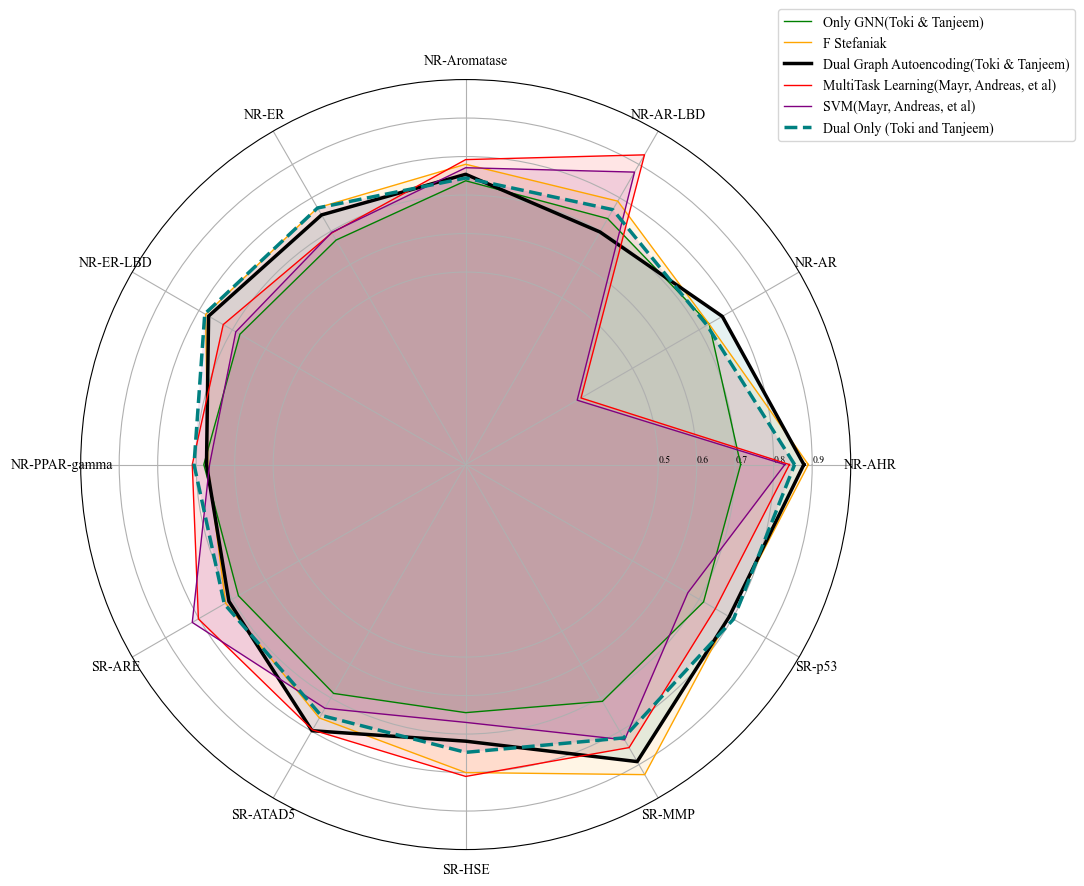

In [83]:

my_prev_results={'NR-AHR':0.7142, 'NR-AR':0.7303, 'NR-AR-LBD':0.7376, 'NR-Aromatase':0.7371, 'NR-ER':0.6733, 'NR-ER-LBD':0.6771, 'NR-PPAR-gamma':0.6802, 'SR-ARE':0.6816, 'SR-ATAD5':0.6864, 'SR-HSE':0.6444, 'SR-MMP':0.7102, 'SR-p53':0.71344}
paper_results={'NR-AHR':0.89, 'NR-AR':0.73, 'NR-AR-LBD':0.79, 'NR-Aromatase':0.78, 'NR-ER':0.77, 'NR-ER-LBD':0.78, 'NR-PPAR-gamma':0.67, 'SR-ARE':0.72, 'SR-ATAD5':0.76, 'SR-HSE':0.80, 'SR-MMP':0.93, 'SR-p53':0.79}
current_results=[0.87831091, 0.76963351, 0.69755245, 0.75394073, 0.74875   ,
       0.77110727, 0.6732388 , 0.71013705, 0.79822606, 0.7185113 ,
       0.89093576, 0.7904014 ]
Dual_without_bert=auc_scores

MultiTask_Learning = [
    0.8409, 0.3459, 0.9289, 0.7921, 0.6949, 0.7272,
    0.7102, 0.8017, 0.7958, 0.8101, 0.8489, 0.7487
]

SingleTaks_Learning = [
    0.8487,
    0.3755,
    0.8799,
    0.7523,
    0.6659,
    0.6532,
    0.6367,
    0.7927,
    0.7972,
    0.7354,
    0.8485,
    0.6955
]
svm_values = [
    0.8289,
    0.3344,
    0.8771,
    0.7710,
    0.6962,
    0.6895,
    0.6653,
    0.8201,
    0.7310,
    0.6697,
    0.8256,
    0.6662
]

import matplotlib.pyplot as plt
import numpy as np
# Update the radar chart to include the MultiTask_Learning, SingleTask_Learning, and svm_values.

# Radar chart setup
categories = list(my_prev_results.keys())
N = len(categories)

# What will be the angle of each axis in the plot?
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Set the font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Initialize the radar plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Draw one axis per variable + add labels
plt.xticks(angles[:-1], categories, color='black', size=10)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9], ["0.5", "0.6", "0.7", "0.8", "0.9"], color="black", size=7)
plt.ylim(0,1)

# Plot each line graph for different methods
# My previous results
values = list(my_prev_results.values()) + list(my_prev_results.values())[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='Only GNN(Toki & Tanjeem)', color='green')
ax.fill(angles, values, 'green', alpha=0.1)

# Paper results
values = list(paper_results.values()) + list(paper_results.values())[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='F Stefaniak', color='orange')
ax.fill(angles, values, 'orange', alpha=0.1)

# Current results
values = list(current_results) + list(current_results)[:1]
ax.plot(angles, values, linewidth=2.5, linestyle='solid', label='Dual Graph Autoencoding(Toki & Tanjeem)', color='black')
ax.fill(angles, values, 'teal', alpha=0.1)

# MultiTask Learning results
values = MultiTask_Learning + MultiTask_Learning[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='MultiTask Learning(Mayr, Andreas, et al)', color='red')
ax.fill(angles, values, 'red', alpha=0.1)

# # SingleTask Learning results
# values = SingleTaks_Learning + SingleTaks_Learning[:1]
# ax.plot(angles, values, linewidth=1, linestyle='solid', label='SingleTask Learning(Mayr, Andreas, et al)', color='blue')
# ax.fill(angles, values, 'blue', alpha=0.1)

# SVM results
values = svm_values + svm_values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='SVM(Mayr, Andreas, et al)', color='purple')
ax.fill(angles, values, 'purple', alpha=0.1)

# SVM results
values = Dual_without_bert + Dual_without_bert[:1]
ax.plot(angles, values, linewidth=2.5, linestyle='--', label='Dual Only (Toki and Tanjeem)', color='Teal')
ax.fill(angles, values, 'purple', alpha=0.1)

# Add legend at the top right corner
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

#save the plot to high quality png
plt.savefig("radar_chart.png", dpi=300, bbox_inches='tight')

plt.show()




In [61]:
def get_mean_auc(scores):
    values = list(scores.values())
    print(sum(values) / len(values))

get_mean_auc(my_prev_results)
get_mean_auc(paper_results)

0.6988200000000001
0.7841666666666667


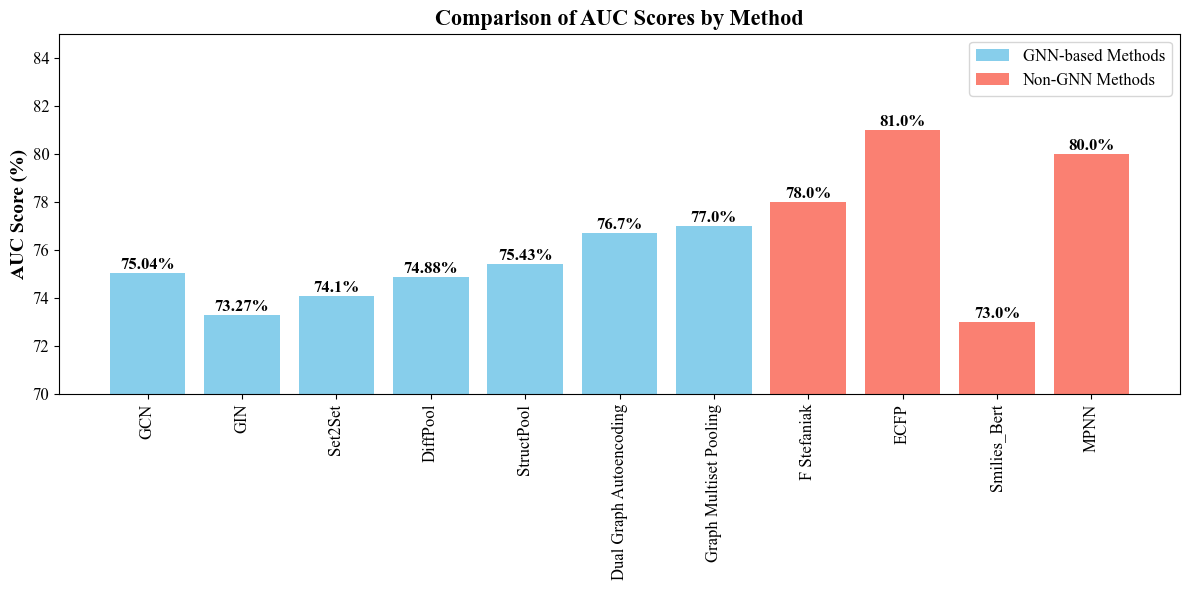

In [68]:
import matplotlib.pyplot as plt

# Provided AUC scores
GNN_aucs = {
    "GCN": 75.04,
    "GIN": 73.27,
    "Set2Set": 74.10,
    "DiffPool": 74.88,
    "StructPool": 75.43,
    "Dual Graph Autoencoding": 76.7,
    "Graph Multiset Pooling": 77.0,
    "F Stefaniak": 78.0,
    "ECFP": 81.0,
    "Smilies_Bert": 73.0,
    "MPNN": 80.0
}

# Split the dictionary into GNN-based and non-GNN methods
gnn_methods = list(GNN_aucs.keys())[:7]
gnn_aucs = list(GNN_aucs.values())[:7]
non_gnn_methods = list(GNN_aucs.keys())[7:]
non_gnn_aucs = list(GNN_aucs.values())[7:]

# Increase the size of the plot for better visibility
plt.figure(figsize=(12, 6))

# Create the bar chart for GNN-based methods
plt.bar(gnn_methods, gnn_aucs, color='skyblue', label='GNN-based Methods')

# Create the bar chart for non-GNN methods
plt.bar(non_gnn_methods, non_gnn_aucs, color='salmon', label='Non-GNN Methods')

# Make the chart elegant
plt.title('Comparison of AUC Scores by Method', fontsize=16, fontweight='bold', fontname='Times New Roman')
# plt.xlabel('Method', fontsize=14, fontweight='bold', fontname='Times New Roman')
plt.ylabel('AUC Score (%)', fontsize=14, fontweight='bold', fontname='Times New Roman')
plt.xticks(rotation=90, fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')
plt.ylim(70, 85)  # Extend the y-axis for visual clarity
plt.legend(fontsize=12)

# Adding value labels on top of each bar
for method, auc in GNN_aucs.items():
    plt.text(method, auc, f'{auc}%', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Show the plot
plt.tight_layout()
#save the plot to high quality png
plt.savefig("bar_chart.png", dpi=300, bbox_inches='tight')
plt.show()


# Dataset analysis


In [96]:
import pandas as pd
import glob

# Collect data from all files
data = []
for file in glob.glob("Seperated_dataset/*"):
    labels = torch.load(f"{file}/test_labels.pt")
    file = file.split('\\')[1]  # Extract filename from path
    data.append({
        "File": file,
        "Number of Labels": len(labels),
        "Number of Positive Labels": sum(labels),
        "Number of Negative Labels": len(labels) - sum(labels),
        "Positive Ratio": round(sum(labels) / len(labels), 2),  # Round to 2 decimals
        "Negative Ratio": round((len(labels) - sum(labels)) / len(labels), 2),  # Round to 2 decimals
    })

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Set the index to the "File" column and format the table
formatted_table = df.set_index("File").to_string(index=True, justify='center')

# Print the formatted table
print(formatted_table)

# Save as CSV
df.to_csv("dataset_statistics.csv", index=True)  # Include index in CSV


               Number of Labels  Number of Positive Labels  Number of Negative Labels  Positive Ratio  Negative Ratio
File                                                                                                                 
nr-ahr                610                   73                         537                  0.12            0.88     
nr-ar                 586                   12                         574                  0.02            0.98     
nr-ar-lbd             582                    8                         574                  0.01            0.99     
nr-aromatase          528                   39                         489                  0.07            0.93     
nr-er                 516                   51                         465                  0.10            0.90     
nr-er-lbd             600                   20                         580                  0.03            0.97     
nr-ppar-gamma         605                   31          